# CAPSTONE PROJECT

## TABLE OF CONTENT


#### <b> <a href='#chapter1'>1. Data Collection </a>  
    
#### <b> <a href='#chapter2'> 2. Data Preprocessing </a>
    
#### <b> <a href='#chapter3'>3. Model Building </a>
   
#### <b> <a href='#chapter4'>4. Portfolio Performance </a>  

#### <b> <a href='#chapter5'>5. Future Prediction </a>  


# <h2> <b> 1. Data Collection <a class='anchor' id='chapter1'></a>

- Equity ETF: S&P500 (SPY)
- Bond ETF: Vanguard Total Bond Market Index Fund (BND)
- Commodities ETF: abrdn Bloomberg All Commodity Longer Dated Strategy K-1 Free ETF (BCD)
- Cryptocurrency: Bitcoin (BTC)

**Collect all-time data from yfinance**

In [73]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import cvxpy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [74]:
df = yf.download(tickers = 'SPY BND BCD BTC-USD', interval = '1d', end = '2024-01-01')['Adj Close']
df.dropna(inplace = True)
df

[*********************100%%**********************]  4 of 4 completed


Ticker,BCD,BND,BTC-USD,SPY
Date,,,,
2017-03-31,20.023758,67.199875,1071.790039,210.044312
2017-04-03,20.095846,67.444054,1143.810059,209.679062
2017-04-04,20.095846,67.369331,1133.250000,209.812637
2017-04-05,20.095846,67.427452,1124.780029,209.188995
2017-04-06,20.171934,67.452347,1182.680054,209.777008
...,...,...,...,...
2023-12-22,30.780001,73.148201,43997.902344,473.649994
2023-12-26,30.990000,73.217995,42520.402344,475.649994
2023-12-27,31.049999,73.686646,43442.855469,476.510010


# <h2> <b> 2. Data Preprocessing <a class='anchor' id='chapter2'></a>

In [75]:
returns = df.pct_change(1).dropna()
returns

Ticker,BCD,BND,BTC-USD,SPY
Date,,,,
2017-04-03,0.003600,0.003634,0.067196,-0.001739
2017-04-04,0.000000,-0.001108,-0.009232,0.000637
2017-04-05,0.000000,0.000863,-0.007474,-0.002972
2017-04-06,0.003786,0.000369,0.051477,0.002811
2017-04-07,-0.000198,-0.002216,-0.004887,-0.001019
...,...,...,...,...
2023-12-22,0.001627,-0.000667,0.002935,0.002010
2023-12-26,0.006823,0.000954,-0.033581,0.004223
2023-12-27,0.001936,0.006401,0.021694,0.001808


In [76]:
returns.sum(axis = 0)

Ticker
BCD        0.492815
BND        0.099401
BTC-USD    5.466173
SPY        0.943503
dtype: float64

#### Graph daily price and returns

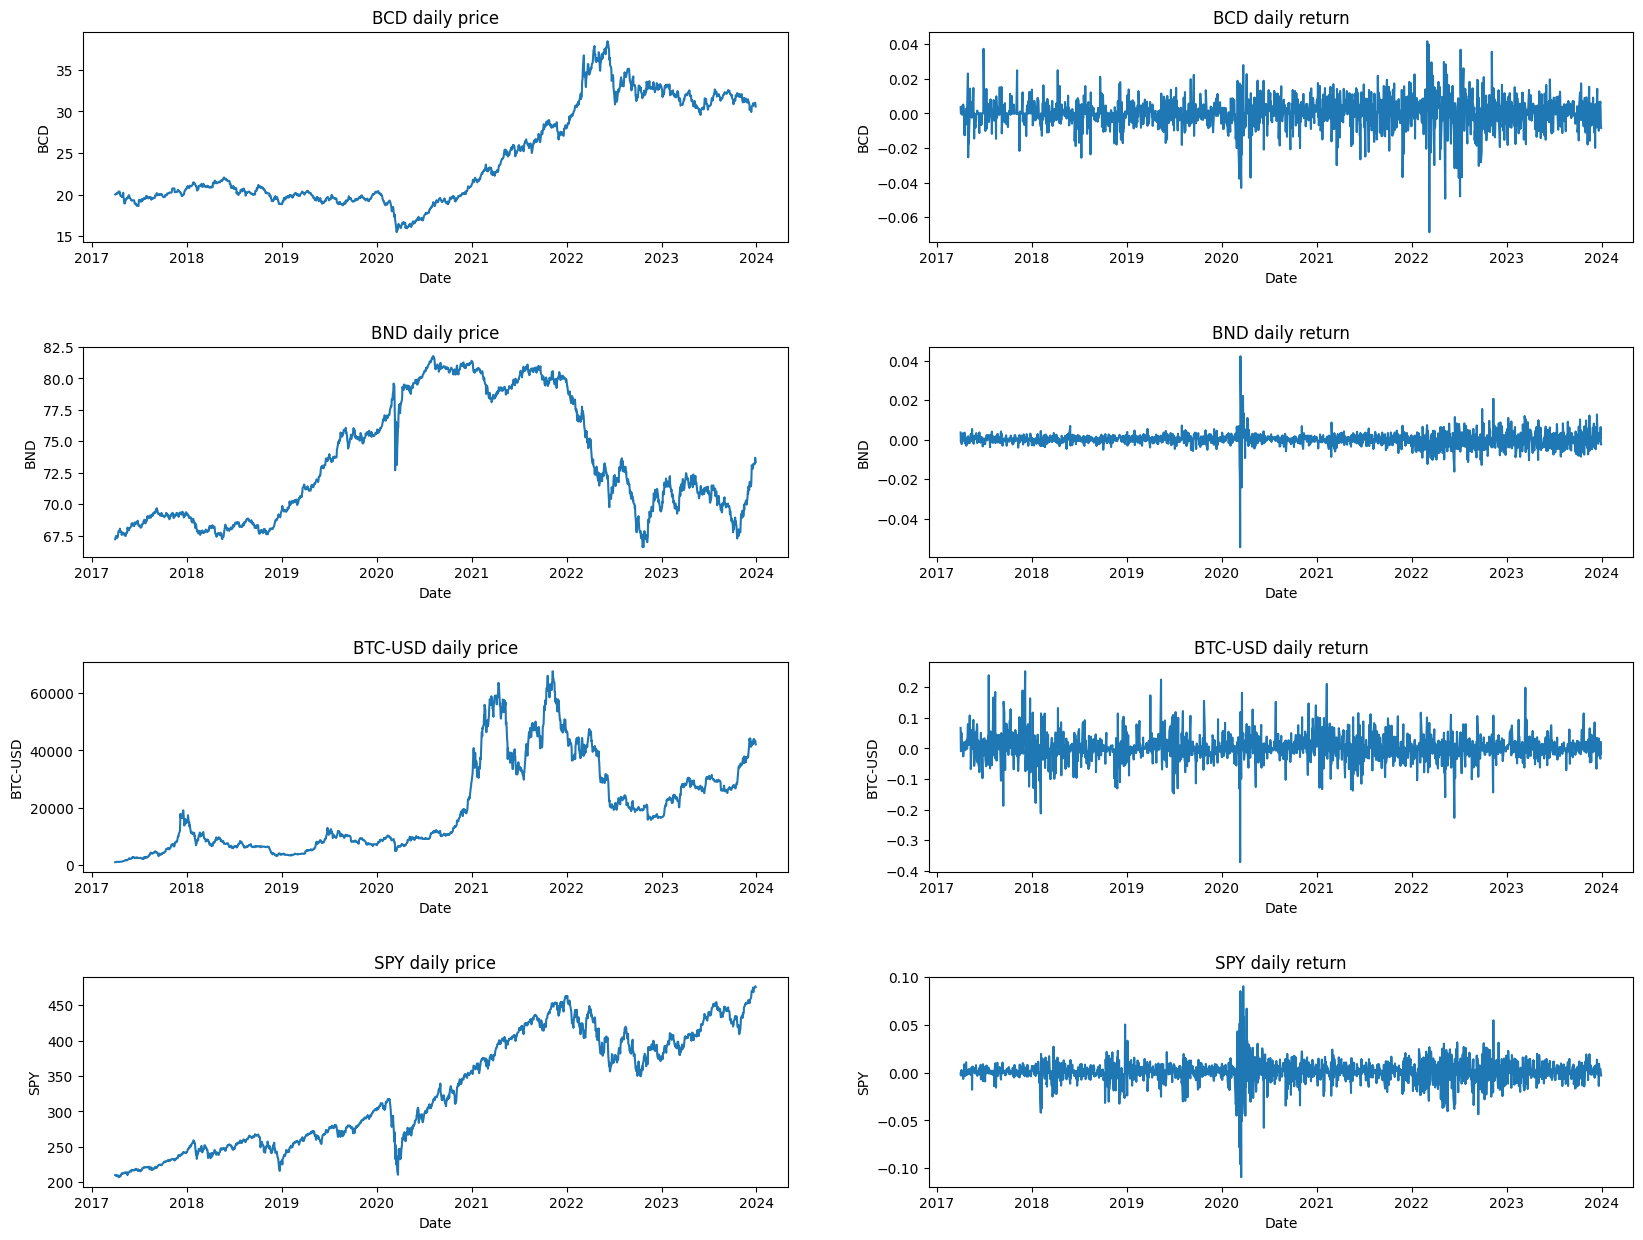

In [77]:
col = list(df.columns)


fig,axes = plt.subplots(4,2,figsize=(20,15))
for index,col in enumerate(col):
    x, y = index, 0
    sns.lineplot(x= df.index, y=df[col],ax=axes[x,y]).set(title=col+' daily price')
    x, y = index, 1
    sns.lineplot(x = returns.index, y= returns[col],ax=axes[x,y]).set(title=col+' daily return')

plt.subplots_adjust(hspace=0.5)

#### Define allocation for model training

In [78]:
# Number of assets
num_assets = len(returns.columns)

# Create a DataFrame to store daily weights
daily_weights = pd.DataFrame(index=returns.index, columns=returns.columns)

# Portfolio Optimization
for date in returns.index:
    current_returns = returns.loc[date].values
    weights = cp.Variable(num_assets)

    # Objective function - Maximize expected return
    objective = cp.Maximize(current_returns @ weights)

    # Constraints - Weights sum to 1 and ensure non-negative weights
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Store the optimal weights for the current date
    daily_weights.loc[date] = weights.value

# Add the daily weights to the returns DataFrame
returns = pd.concat([returns, daily_weights], axis=1)

In [79]:
returns.columns = ['BCD','BND','BTC-USD','SPY','BCD_w','BND_w','BTC-USD_w','SPY_w']
returns = returns.astype('float')
returns.dtypes

BCD          float64
BND          float64
BTC-USD      float64
SPY          float64
BCD_w        float64
BND_w        float64
BTC-USD_w    float64
SPY_w        float64
dtype: object

In [80]:
returns

,BCD,BND,BTC-USD,SPY,BCD_w,BND_w,BTC-USD_w,SPY_w
Date,,,,,,,,
2017-04-03,0.003600,0.003634,0.067196,-0.001739,4.233655e-10,4.216919e-10,1.000000e+00,6.575051e-10
2017-04-04,0.000000,-0.001108,-0.009232,0.000637,9.567803e-08,2.755177e-07,5.397070e-08,9.999996e-01
2017-04-05,0.000000,0.000863,-0.007474,-0.002972,8.253140e-08,9.999997e-01,5.433214e-08,1.229063e-07
2017-04-06,0.003786,0.000369,0.051477,0.002811,3.984492e-10,4.133895e-10,1.000000e+00,4.003481e-10
2017-04-07,-0.000198,-0.002216,-0.004887,-0.001019,9.999995e-01,2.630937e-07,1.162463e-07,7.953213e-08
...,...,...,...,...,...,...,...,...
2023-12-22,0.001627,-0.000667,0.002935,0.002010,2.267530e-07,1.352636e-07,9.999996e-01,5.961935e-08
2023-12-26,0.006823,0.000954,-0.033581,0.004223,1.000000e+00,1.739725e-08,4.398125e-09,1.059935e-08
2023-12-27,0.001936,0.006401,0.021694,0.001808,1.003806e-09,1.218470e-09,1.000000e+00,9.979827e-10


# <h2> <b> 3. Model Building <a class='anchor' id='chapter3'></a>

### 3.1. Use LSTM to predict price

In [81]:
def prediction_model(df,ticker, time_seq):
    ticker_close = df[ticker].values.reshape(-1, 1)

    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    ticker_close_scaled = scaler.fit_transform(ticker_close)

    # Function to prepare data for LSTM
    def prepare_data(data_scaled):
        X, y = [], []
        for i in range(time_seq, len(data_scaled)):
            X.append(data_scaled[i-time_seq:i, 0])
            y.append(data_scaled[i, 0])
        return np.array(X), np.array(y)

    # Prepare data for training
    X_ticker, y_ticker = prepare_data(ticker_close_scaled)

    # Reshape data for LSTM input (batch_size, timesteps, input_dim)
    X_ticker = np.reshape(X_ticker, (X_ticker.shape[0], X_ticker.shape[1], 1))

    # Function to create LSTM model
    def create_lstm_model(X_train):
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Function to train LSTM model
    def train_lstm_model(model, X_train, y_train, epochs, batch_size):
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def make_predictions(model, X):
        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        return predictions

    # Function to evaluate the model
    def evaluate_model(model, X, y):
        predictions = make_predictions(model, X)
        y = y.reshape(-1, 1)  # Reshape y to 2D array
        mse = mean_squared_error(scaler.inverse_transform(y), predictions)
        return mse

    # Function to plot predictions
    def plot_predictions(actual, predictions, title):
        plt.figure(figsize=(15, 8))
        plt.plot(actual, label='Actual Price')
        plt.plot(predictions, label='Predicted Price')
        plt.legend()
        plt.title(title)
        plt.show()

    # Train LSTM models
    model_ticker = create_lstm_model(X_ticker)
    train_lstm_model(model_ticker, X_ticker, y_ticker, epochs=10, batch_size=32)

    # Evaluate and plot predictions
    mse_ticker = evaluate_model(model_ticker, X_ticker, y_ticker)
    print('Mean Squared Error',ticker,':',mse_ticker)
    ticker_predictions = make_predictions(model_ticker, X_ticker)

    # Predict BTC prices for the future
    future_time_steps = 365  # Assuming you want to predict for the next year

    # Use the last 'time_steps' values from the original data to predict the future
    future_data = ticker_close_scaled[-time_seq:]

    for _ in range(future_time_steps):
        X_future = future_data[-time_seq:].reshape(1, time_seq, 1)
        predicted_price = model_ticker.predict(X_future)[0, 0]
        future_data = np.append(future_data, [[predicted_price]], axis=0)

    # Inverse transform the normalized data to get the actual prices
    predicted_prices = scaler.inverse_transform(future_data[-future_time_steps:].reshape(-1, 1))

    # Create a DataFrame for the predicted prices
    predicted_dates = pd.date_range(start=df.index[-1], periods=future_time_steps + 1, freq='D')[1:]
    predicted_df = pd.DataFrame({ticker + '_predicted_price': predicted_prices.flatten()}, index=predicted_dates)

    # Save the predicted prices in the existing DataFrame
    df = pd.concat([df, predicted_df], axis=1)

    plot_predictions(ticker_close[time_seq:], ticker_predictions, title = ticker + ' Price Prediction')

    return df

Epoch 1/10
53/53 [==============================] - 6s 11ms/step - loss: 0.0641
Epoch 2/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0013
Epoch 3/10
53/53 [==============================] - 1s 11ms/step - loss: 9.5472e-04
Epoch 4/10
53/53 [==============================] - 1s 11ms/step - loss: 8.2177e-04
Epoch 5/10
53/53 [==============================] - 1s 11ms/step - loss: 7.3671e-04
Epoch 6/10
53/53 [==============================] - 1s 16ms/step - loss: 6.6673e-04
Epoch 7/10
53/53 [==============================] - 1s 17ms/step - loss: 6.6067e-04
Epoch 8/10
53/53 [==============================] - 1s 18ms/step - loss: 6.3920e-04
Epoch 9/10
53/53 [==============================] - 1s 13ms/step - loss: 6.3436e-04
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error SPY : 46.42157697782895
1/1 [==============================] - 0s 36ms/step


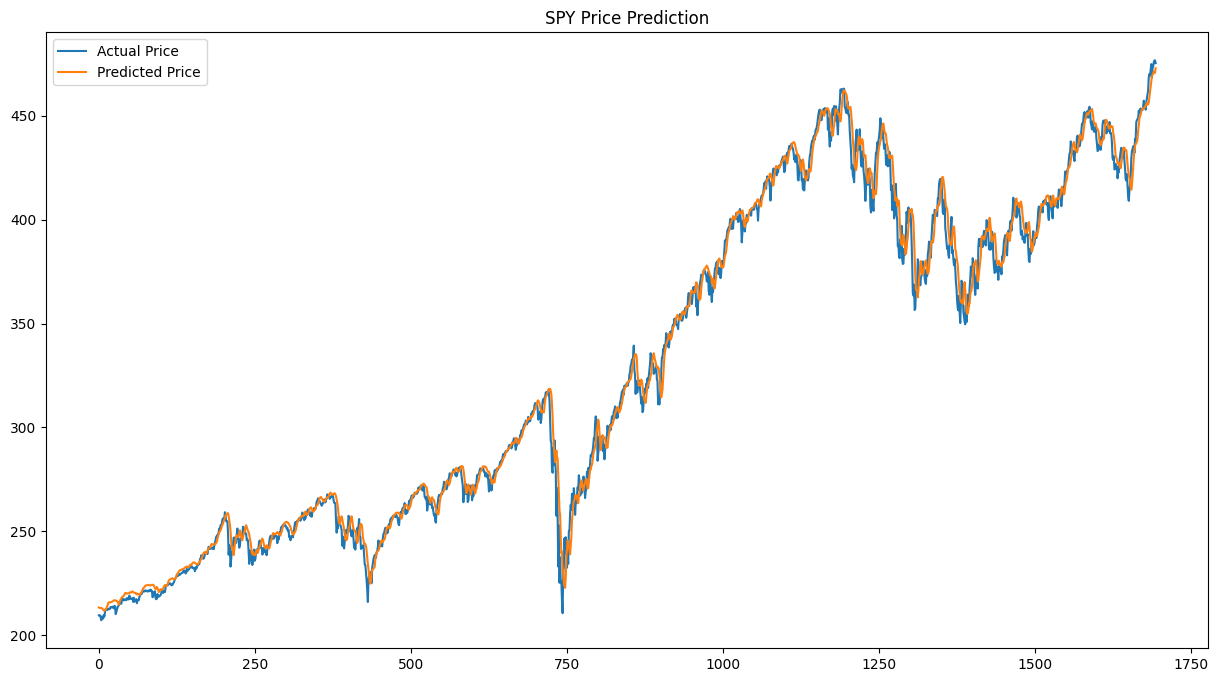

In [82]:
model_SPY = prediction_model(df,'SPY',5)

Epoch 1/10
53/53 [==============================] - 6s 11ms/step - loss: 0.0551
Epoch 2/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 3/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 4/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 5/10
53/53 [==============================] - 1s 11ms/step - loss: 9.8601e-04
Epoch 6/10
53/53 [==============================] - 1s 11ms/step - loss: 9.9343e-04
Epoch 7/10
53/53 [==============================] - 1s 16ms/step - loss: 9.5512e-04
Epoch 8/10
53/53 [==============================] - 1s 17ms/step - loss: 9.5581e-04
Epoch 9/10
53/53 [==============================] - 1s 18ms/step - loss: 0.0010
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error BND : 0.22052006075258224
1/1 [==============================] - 0s 35ms/step


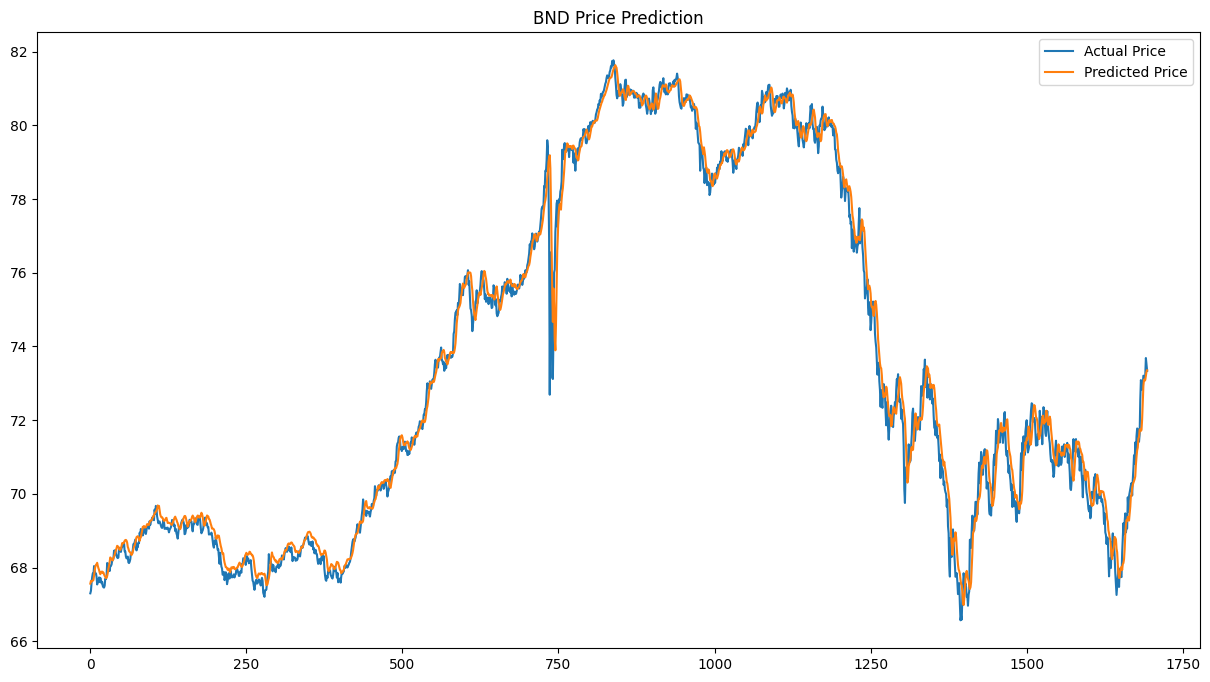

In [83]:
model_BND = prediction_model(df,'BND',5)

Epoch 1/10
53/53 [==============================] - 6s 11ms/step - loss: 0.0411
Epoch 2/10
53/53 [==============================] - 1s 11ms/step - loss: 9.4352e-04
Epoch 3/10
53/53 [==============================] - 1s 12ms/step - loss: 6.2416e-04
Epoch 4/10
53/53 [==============================] - 1s 12ms/step - loss: 5.1478e-04
Epoch 5/10
53/53 [==============================] - 1s 12ms/step - loss: 5.2056e-04
Epoch 6/10
53/53 [==============================] - 1s 12ms/step - loss: 4.7140e-04
Epoch 7/10
53/53 [==============================] - 1s 18ms/step - loss: 4.8575e-04
Epoch 8/10
53/53 [==============================] - 1s 18ms/step - loss: 4.1946e-04
Epoch 9/10
53/53 [==============================] - 1s 16ms/step - loss: 4.2029e-04
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error BCD : 0.21346663917863817
1/1 [==============================] - 0s 36ms/step


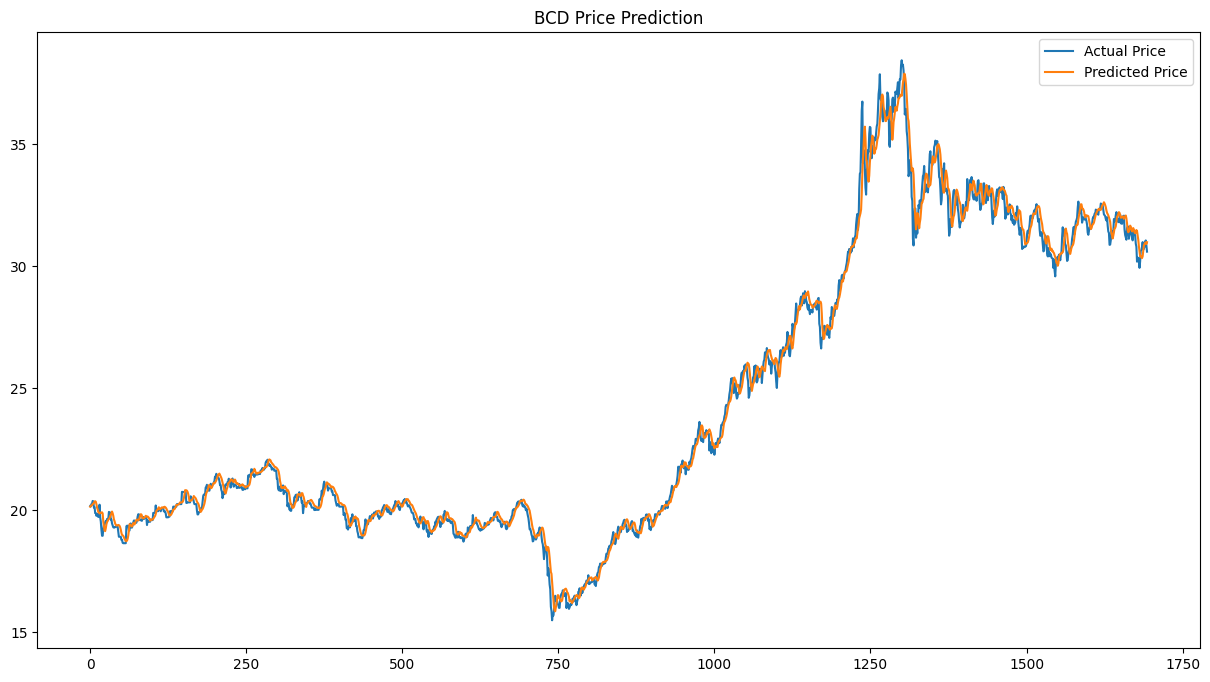

In [84]:
model_BCD = prediction_model(df,'BCD',5)

Epoch 1/10
53/53 [==============================] - 6s 11ms/step - loss: 0.0292
Epoch 2/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 3/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 4/10
53/53 [==============================] - 1s 11ms/step - loss: 9.1028e-04
Epoch 5/10
53/53 [==============================] - 1s 11ms/step - loss: 9.1253e-04
Epoch 6/10
53/53 [==============================] - 1s 11ms/step - loss: 9.0295e-04
Epoch 7/10
53/53 [==============================] - 1s 16ms/step - loss: 9.3787e-04
Epoch 8/10
53/53 [==============================] - 1s 17ms/step - loss: 8.8866e-04
Epoch 9/10
53/53 [==============================] - 1s 18ms/step - loss: 9.6044e-04
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error BTC-USD : 4899214.6739540715
1/1 [==============================] - 0s 22ms/step


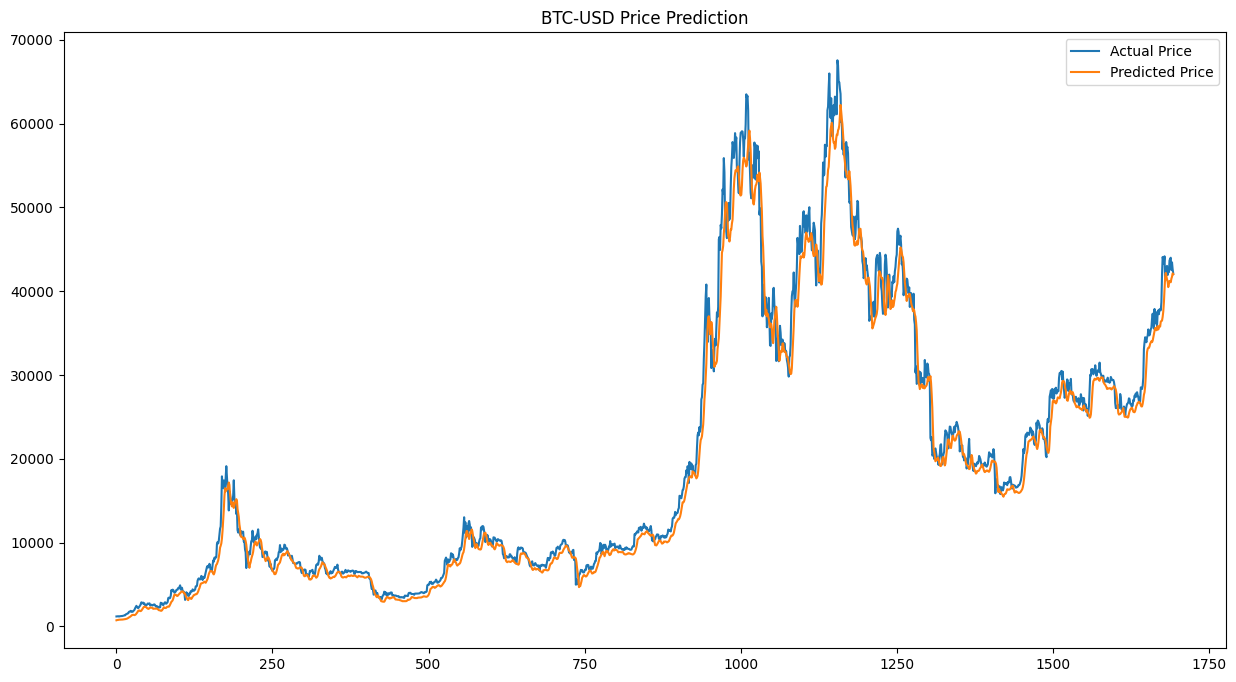

In [85]:
model_BTC = prediction_model(df,'BTC-USD',5)

In [86]:
common_columns = df.columns

# Concatenate the DataFrames along the rows
result_df = pd.concat([model_BCD, model_BND, model_BTC, model_SPY], axis = 1)
# Remove duplicated columns based on common columns
result_df = result_df.loc[:, ~result_df.columns.duplicated()]

result_df

,BCD,BND,BTC-USD,SPY,BCD_predicted_price,BND_predicted_price,BTC-USD_predicted_price,SPY_predicted_price
2017-03-31,20.023758,67.199875,1071.790039,210.044312,NaN,NaN,NaN,NaN
2017-04-03,20.095846,67.444054,1143.810059,209.679062,NaN,NaN,NaN,NaN
2017-04-04,20.095846,67.369331,1133.250000,209.812637,NaN,NaN,NaN,NaN
2017-04-05,20.095846,67.427452,1124.780029,209.188995,NaN,NaN,NaN,NaN
2017-04-06,20.171934,67.452347,1182.680054,209.777008,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-12-24,NaN,NaN,NaN,NaN,34.286585,80.504179,-6636.533244,460.803477
2024-12-25,NaN,NaN,NaN,NaN,34.286748,80.506821,-6650.862964,460.803365
2024-12-26,NaN,NaN,NaN,NaN,34.286902,80.509425,-6664.975688,460.803284
2024-12-27,NaN,NaN,NaN,NaN,34.287066,80.511985,-6678.877359,460.803204


In [87]:
returns['SPY_Label'] = (returns['SPY_w'] >= 0.5).astype(int)
returns['BND_Label'] = (returns['BND_w'] >= 0.5).astype(int)
returns['BCD_Label'] = (returns['BCD_w'] >= 0.5).astype(int)
returns['BTC-USD_Label'] = (returns['BTC-USD_w'] >= 0.5).astype(int)


# Features and target variable
train_size = int(len(returns) * 0.8)
train, test = returns[:train_size], returns[train_size:]

# Model Training
features = ['SPY', 'BND', 'BCD', 'BTC-USD']
labels = ['SPY_Label', 'BND_Label', 'BCD_Label', 'BTC-USD_Label']
X_train, y_train = train[features], train[labels]
X_test, y_test = test[features], test[labels]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [88]:
# Predictions
predictions = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9264705882352942


In [89]:
X = returns[features]

# Predict probabilities for each label on the test set
proba_predictions = rf_model.predict_proba(X)

# Convert proba_predictions to a NumPy array
proba_predictions_array = np.array(proba_predictions)

# Extract the probability of the positive class for each label
proba_positive_class = proba_predictions_array[:, :, 1].T

# Create a DataFrame with predicted probabilities
proba_df = pd.DataFrame(proba_positive_class, columns=[f'{label}_Proba_Predicted' for label in labels])

# Concatenate the predicted probabilities DataFrame with the original DataFrame
returns = pd.concat([returns.reset_index(drop=True), proba_df], axis=1)

# proba_df.sum(axis = 1)

In [97]:
returns

,BCD,BND,BTC-USD,SPY,BCD_w,BND_w,BTC-USD_w,SPY_w,SPY_Label,BND_Label,BCD_Label,BTC-USD_Label,SPY_Label_Proba_Predicted,BND_Label_Proba_Predicted,BCD_Label_Proba_Predicted,BTC-USD_Label_Proba_Predicted,Portfolio_Return,Cumulative_Return
Date,,,,,,,,,,,,,,,,,,
2017-04-03,0.003600,0.003634,0.067196,-0.001739,4.233655e-10,4.216919e-10,1.000000e+00,6.575051e-10,0,0,0,1,0.00,0.00,0.00,1.00,0.067196,1.067196e+00
2017-04-04,0.000000,-0.001108,-0.009232,0.000637,9.567803e-08,2.755177e-07,5.397070e-08,9.999996e-01,1,0,0,0,0.89,0.02,0.09,0.00,0.000545,1.067777e+00
2017-04-05,0.000000,0.000863,-0.007474,-0.002972,8.253140e-08,9.999997e-01,5.433214e-08,1.229063e-07,0,1,0,0,0.00,0.98,0.02,0.00,0.000845,1.068680e+00
2017-04-06,0.003786,0.000369,0.051477,0.002811,3.984492e-10,4.133895e-10,1.000000e+00,4.003481e-10,0,0,0,1,0.00,0.00,0.00,1.00,0.051477,1.123692e+00
2017-04-07,-0.000198,-0.002216,-0.004887,-0.001019,9.999995e-01,2.630937e-07,1.162463e-07,7.953213e-08,0,0,1,0,0.03,0.05,0.92,0.00,-0.000324,1.123328e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.001627,-0.000667,0.002935,0.002010,2.267530e-07,1.352636e-07,9.999996e-01,5.961935e-08,0,0,0,1,0.40,0.03,0.05,0.52,0.002391,1.039775e+14
2023-12-26,0.006823,0.000954,-0.033581,0.004223,1.000000e+00,1.739725e-08,4.398125e-09,1.059935e-08,0,0,1,0,0.00,0.00,1.00,0.00,0.006823,1.046869e+14
2023-12-27,0.001936,0.006401,0.021694,0.001808,1.003806e-09,1.218470e-09,1.000000e+00,9.979827e-10,0,0,0,1,0.01,0.03,0.00,0.96,0.021037,1.068891e+14


# <h2> <b> 4. Portfolio Performance <a class='anchor' id='chapter4'></a>

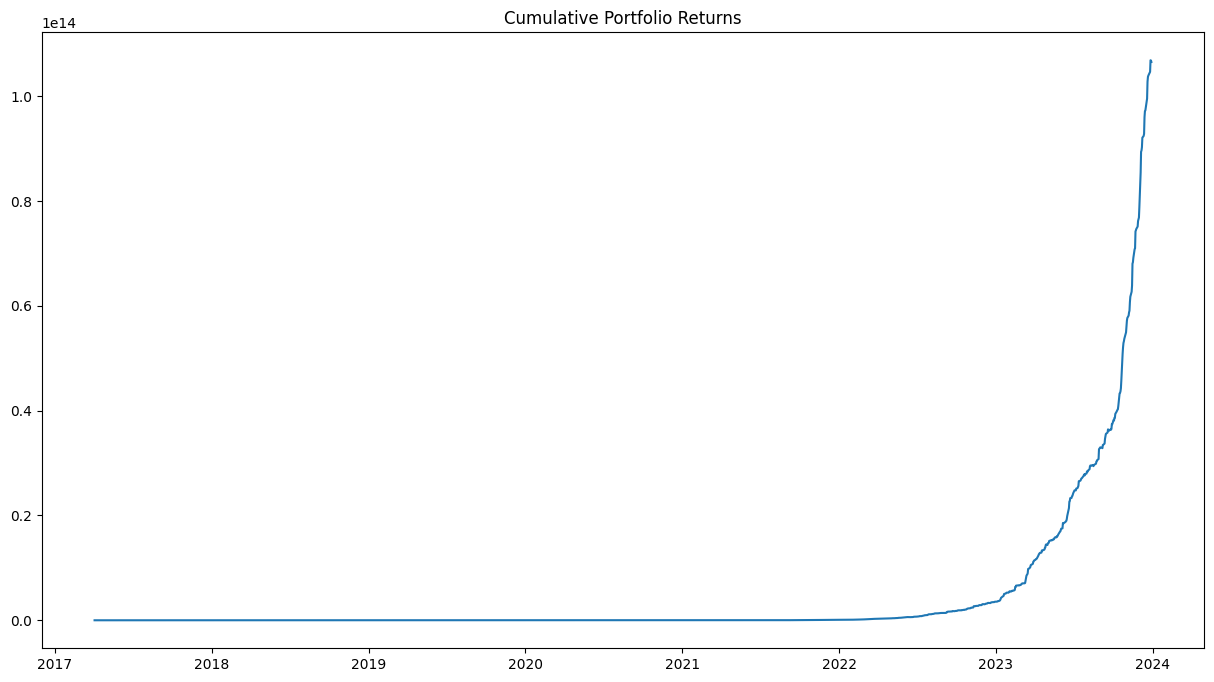

Portfolio Volatility: 0.028825930783866003
Sharpe Ratio: 0.6796114155042516


In [91]:
returns.set_index(df.index[1:],inplace = True)
# Calculate portfolio returns
returns['Portfolio_Return'] = (returns['SPY_Label_Proba_Predicted'] * returns['SPY'] +
                                 returns['BND_Label_Proba_Predicted'] * returns['BND'] +
                                 returns['BCD_Label_Proba_Predicted'] * returns['BCD'] +
                                  returns['BTC-USD_Label_Proba_Predicted'] * returns['BTC-USD'])

# Calculate cumulative portfolio returns
returns['Cumulative_Return'] = (returns['Portfolio_Return'] + 1).cumprod()

# Plot cumulative portfolio returns
plt.figure(figsize=(15, 8))
plt.plot(returns['Cumulative_Return'])
plt.title('Cumulative Portfolio Returns')
plt.show()

# Calculate portfolio volatility
portfolio_volatility = returns['Portfolio_Return'].std()
print('Portfolio Volatility:', portfolio_volatility)

# Calculate portfolio Sharpe ratio
sharpe_ratio = returns['Portfolio_Return'].mean() / portfolio_volatility
print('Sharpe Ratio:', sharpe_ratio)


# <h2> <b> 5. Future allocation <a class='anchor' id='chapter5'></a>

In [92]:
future_df = result_df[result_df.columns[4:]].dropna()
future_df


,BCD_predicted_price,BND_predicted_price,BTC-USD_predicted_price,SPY_predicted_price
2023-12-30,31.035051,73.419276,41734.157477,473.797990
2023-12-31,31.083809,73.531113,41263.022596,474.572091
2024-01-01,31.048735,73.640178,41184.277504,474.578309
2024-01-02,30.986281,73.554555,40653.358499,474.105953
2024-01-03,31.016884,73.542403,40261.036087,473.349314
...,...,...,...,...
2024-12-24,34.286585,80.504179,-6636.533244,460.803477
2024-12-25,34.286748,80.506821,-6650.862964,460.803365
2024-12-26,34.286902,80.509425,-6664.975688,460.803284
2024-12-27,34.287066,80.511985,-6678.877359,460.803204


In [93]:
future_returns = future_df.pct_change(1).dropna()
future_returns.columns = features
future_returns

,SPY,BND,BCD,BTC-USD
2023-12-31,0.001571,0.001523,-0.011289,1.633822e-03
2024-01-01,-0.001128,0.001483,-0.001908,1.310044e-05
2024-01-02,-0.002011,-0.001163,-0.012891,-9.953154e-04
2024-01-03,0.000988,-0.000165,-0.009650,-1.595928e-03
2024-01-04,0.005473,0.001014,-0.008407,-8.415101e-04
...,...,...,...,...
2024-12-24,0.000005,0.000033,0.002197,-2.440390e-07
2024-12-25,0.000005,0.000033,0.002159,-2.440390e-07
2024-12-26,0.000005,0.000032,0.002122,-1.743136e-07
2024-12-27,0.000005,0.000032,0.002086,-1.743137e-07


In [94]:
X_24 = future_returns[features]

# Predict probabilities for each label on the test set
proba_predictions = rf_model.predict_proba(X_24)

# Convert proba_predictions to a NumPy array
proba_predictions_array = np.array(proba_predictions)

# Extract the probability of the positive class for each label
proba_positive_class = proba_predictions_array[:, :, 1].T

# Create a DataFrame with predicted probabilities
proba_df = pd.DataFrame(proba_positive_class, columns=[f'{label}_Proba_Predicted' for label in labels])

# Concatenate the predicted probabilities DataFrame with the original DataFrame
future_returns = pd.concat([future_returns.reset_index(drop=True), proba_df], axis=1)

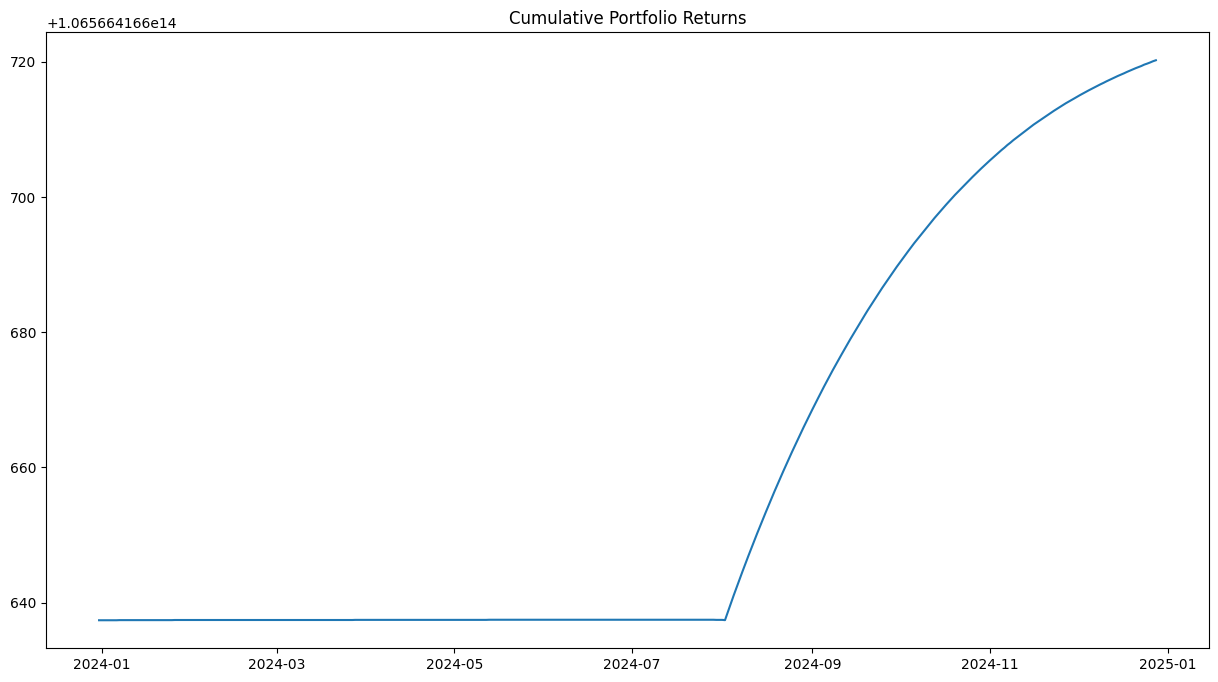

Portfolio Volatility: 0.07680571366763493
Sharpe Ratio: 0.18375789446425414


In [95]:
future_returns.set_index(future_df.index[1:],inplace = True)
# Calculate portfolio returns
future_returns['Portfolio_Return'] = (future_returns['SPY_Label_Proba_Predicted'] * future_returns['SPY'] +
                                 future_returns['BND_Label_Proba_Predicted'] * future_returns['BND'] +
                                 future_returns['BCD_Label_Proba_Predicted'] * future_returns['BCD'] +
                                  future_returns['BTC-USD_Label_Proba_Predicted'] * future_returns['BTC-USD'])

# Calculate cumulative portfolio returns
future_returns['Cumulative_Return'] = (future_returns['Portfolio_Return'] + 1).cumprod() + returns['Cumulative_Return'][-1]

# Plot cumulative portfolio returns
plt.figure(figsize=(15, 8))
plt.plot(future_returns['Cumulative_Return'])
plt.title('Cumulative Portfolio Returns')
plt.show()

# Calculate portfolio volatility
portfolio_volatility = future_returns['Portfolio_Return'].std()
print('Portfolio Volatility:', portfolio_volatility)

# Calculate portfolio Sharpe ratio
sharpe_ratio = future_returns['Portfolio_Return'].mean() / portfolio_volatility
print('Sharpe Ratio:', sharpe_ratio)
